In [1]:
NOTE = 'CatBoost-Plain特徴量ミニマム'
notebook_name = '060'

In [2]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

060_submission.csv 060


In [4]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = CatBoostClassifier(random_state=SEED,
                             train_dir=OUTPUT_DIR,
                             class_weights=CLASS_WEIGHTS,
                             boosting_type='Plain',
                             n_estimators=300,
                             learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [5]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [6]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [7]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['inningNo', 'S', 'O', 'numRunners', 'totalPitchingCount', 'B']


In [8]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [9]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [10]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



0:	learn: 2.0761192	total: 272ms	remaining: 1m 21s
1:	learn: 2.0739977	total: 329ms	remaining: 49s
2:	learn: 2.0708189	total: 420ms	remaining: 41.6s
3:	learn: 2.0665590	total: 474ms	remaining: 35.1s
4:	learn: 2.0625062	total: 589ms	remaining: 34.7s
5:	learn: 2.0594010	total: 660ms	remaining: 32.4s
6:	learn: 2.0571843	total: 775ms	remaining: 32.5s
7:	learn: 2.0553489	total: 866ms	remaining: 31.6s
8:	learn: 2.0512008	total: 962ms	remaining: 31.1s
9:	learn: 2.0475538	total: 1.14s	remaining: 32.9s
10:	learn: 2.0456139	total: 1.22s	remaining: 32.1s
11:	learn: 2.0427594	total: 1.31s	remaining: 31.4s
12:	learn: 2.0402757	total: 1.37s	remaining: 30.4s
13:	learn: 2.0374912	total: 1.52s	remaining: 31s
14:	learn: 2.0354142	total: 1.6s	remaining: 30.5s
15:	learn: 2.0321565	total: 1.71s	remaining: 30.4s
16:	learn: 2.0290084	total: 1.76s	remaining: 29.4s
17:	learn: 2.0267131	total: 1.85s	remaining: 29s
18:	learn: 2.0232081	total: 1.96s	remaining: 29s
19:	learn: 2.0200099	total: 1.99s	remaining: 27.9

163:	learn: 1.7475874	total: 12.1s	remaining: 10.1s
164:	learn: 1.7466718	total: 12.2s	remaining: 9.98s
165:	learn: 1.7451646	total: 12.2s	remaining: 9.88s
166:	learn: 1.7438776	total: 12.3s	remaining: 9.79s
167:	learn: 1.7420966	total: 12.4s	remaining: 9.71s
168:	learn: 1.7404327	total: 12.4s	remaining: 9.63s
169:	learn: 1.7391764	total: 12.5s	remaining: 9.53s
170:	learn: 1.7381378	total: 12.5s	remaining: 9.45s
171:	learn: 1.7367454	total: 12.6s	remaining: 9.38s
172:	learn: 1.7354051	total: 12.7s	remaining: 9.35s
173:	learn: 1.7337622	total: 12.8s	remaining: 9.26s
174:	learn: 1.7324253	total: 12.8s	remaining: 9.17s
175:	learn: 1.7317920	total: 12.9s	remaining: 9.09s
176:	learn: 1.7309590	total: 13s	remaining: 9.03s
177:	learn: 1.7307525	total: 13s	remaining: 8.93s
178:	learn: 1.7295178	total: 13.1s	remaining: 8.83s
179:	learn: 1.7285458	total: 13.2s	remaining: 8.77s
180:	learn: 1.7268387	total: 13.2s	remaining: 8.7s
181:	learn: 1.7250476	total: 13.3s	remaining: 8.62s
182:	learn: 1.724

8:	learn: 2.0464550	total: 602ms	remaining: 19.5s
9:	learn: 2.0432455	total: 665ms	remaining: 19.3s
10:	learn: 2.0396965	total: 839ms	remaining: 22s
11:	learn: 2.0358722	total: 927ms	remaining: 22.2s
12:	learn: 2.0332812	total: 955ms	remaining: 21.1s
13:	learn: 2.0295008	total: 1.04s	remaining: 21.3s
14:	learn: 2.0264077	total: 1.12s	remaining: 21.3s
15:	learn: 2.0232564	total: 1.25s	remaining: 22.1s
16:	learn: 2.0208439	total: 1.3s	remaining: 21.7s
17:	learn: 2.0183051	total: 1.4s	remaining: 21.9s
18:	learn: 2.0143603	total: 1.5s	remaining: 22.2s
19:	learn: 2.0107161	total: 1.57s	remaining: 22s
20:	learn: 2.0083573	total: 1.61s	remaining: 21.5s
21:	learn: 2.0060091	total: 1.67s	remaining: 21.2s
22:	learn: 2.0015960	total: 1.71s	remaining: 20.5s
23:	learn: 1.9985503	total: 1.79s	remaining: 20.6s
24:	learn: 1.9946576	total: 1.9s	remaining: 20.9s
25:	learn: 1.9917878	total: 1.98s	remaining: 20.9s
26:	learn: 1.9884343	total: 2.05s	remaining: 20.7s
27:	learn: 1.9860872	total: 2.14s	remaini

169:	learn: 1.7190953	total: 14.6s	remaining: 11.1s
170:	learn: 1.7175353	total: 14.6s	remaining: 11s
171:	learn: 1.7160030	total: 14.7s	remaining: 10.9s
172:	learn: 1.7148717	total: 14.8s	remaining: 10.8s
173:	learn: 1.7137430	total: 14.9s	remaining: 10.8s
174:	learn: 1.7122975	total: 14.9s	remaining: 10.7s
175:	learn: 1.7114407	total: 15s	remaining: 10.6s
176:	learn: 1.7098086	total: 15.1s	remaining: 10.5s
177:	learn: 1.7096698	total: 15.1s	remaining: 10.4s
178:	learn: 1.7085312	total: 15.2s	remaining: 10.3s
179:	learn: 1.7076397	total: 15.3s	remaining: 10.2s
180:	learn: 1.7063492	total: 15.3s	remaining: 10.1s
181:	learn: 1.7047273	total: 15.4s	remaining: 9.97s
182:	learn: 1.7037883	total: 15.4s	remaining: 9.87s
183:	learn: 1.7026595	total: 15.5s	remaining: 9.77s
184:	learn: 1.7013810	total: 15.5s	remaining: 9.66s
185:	learn: 1.7003546	total: 15.6s	remaining: 9.55s
186:	learn: 1.6988544	total: 15.7s	remaining: 9.46s
187:	learn: 1.6975500	total: 15.8s	remaining: 9.39s
188:	learn: 1.69

16:	learn: 2.0185263	total: 1.21s	remaining: 20.1s
17:	learn: 2.0150452	total: 1.25s	remaining: 19.6s
18:	learn: 2.0126488	total: 1.33s	remaining: 19.6s
19:	learn: 2.0084551	total: 1.41s	remaining: 19.7s
20:	learn: 2.0047710	total: 1.45s	remaining: 19.3s
21:	learn: 2.0013341	total: 1.55s	remaining: 19.6s
22:	learn: 1.9972056	total: 1.65s	remaining: 19.9s
23:	learn: 1.9938790	total: 1.73s	remaining: 19.9s
24:	learn: 1.9912015	total: 1.8s	remaining: 19.8s
25:	learn: 1.9887594	total: 1.85s	remaining: 19.5s
26:	learn: 1.9855032	total: 1.91s	remaining: 19.3s
27:	learn: 1.9834865	total: 2s	remaining: 19.4s
28:	learn: 1.9806973	total: 2.09s	remaining: 19.5s
29:	learn: 1.9773711	total: 2.19s	remaining: 19.7s
30:	learn: 1.9745072	total: 2.31s	remaining: 20s
31:	learn: 1.9706095	total: 2.38s	remaining: 19.9s
32:	learn: 1.9685402	total: 2.46s	remaining: 19.9s
33:	learn: 1.9652824	total: 2.55s	remaining: 19.9s
34:	learn: 1.9615543	total: 2.68s	remaining: 20.3s
35:	learn: 1.9585818	total: 2.87s	rem

178:	learn: 1.7075361	total: 13.5s	remaining: 9.11s
179:	learn: 1.7063843	total: 13.5s	remaining: 9.02s
180:	learn: 1.7050523	total: 13.6s	remaining: 8.96s
181:	learn: 1.7035195	total: 13.7s	remaining: 8.89s
182:	learn: 1.7028022	total: 13.8s	remaining: 8.82s
183:	learn: 1.7016083	total: 13.8s	remaining: 8.73s
184:	learn: 1.7014399	total: 13.9s	remaining: 8.64s
185:	learn: 1.7008058	total: 14s	remaining: 8.55s
186:	learn: 1.6998674	total: 14s	remaining: 8.46s
187:	learn: 1.6990906	total: 14.1s	remaining: 8.38s
188:	learn: 1.6979694	total: 14.1s	remaining: 8.28s
189:	learn: 1.6965057	total: 14.1s	remaining: 8.19s
190:	learn: 1.6950772	total: 14.2s	remaining: 8.11s
191:	learn: 1.6935770	total: 14.3s	remaining: 8.02s
192:	learn: 1.6926174	total: 14.3s	remaining: 7.93s
193:	learn: 1.6916958	total: 14.3s	remaining: 7.84s
194:	learn: 1.6908766	total: 14.4s	remaining: 7.74s
195:	learn: 1.6897489	total: 14.4s	remaining: 7.66s
196:	learn: 1.6885192	total: 14.5s	remaining: 7.58s
197:	learn: 1.68

23:	learn: 1.9920635	total: 2.19s	remaining: 25.2s
24:	learn: 1.9888029	total: 2.38s	remaining: 26.2s
25:	learn: 1.9868769	total: 2.42s	remaining: 25.5s
26:	learn: 1.9829218	total: 2.49s	remaining: 25.2s
27:	learn: 1.9800443	total: 2.55s	remaining: 24.8s
28:	learn: 1.9788383	total: 2.62s	remaining: 24.5s
29:	learn: 1.9768763	total: 2.68s	remaining: 24.2s
30:	learn: 1.9734874	total: 2.74s	remaining: 23.8s
31:	learn: 1.9700967	total: 2.77s	remaining: 23.2s
32:	learn: 1.9670678	total: 2.93s	remaining: 23.7s
33:	learn: 1.9637984	total: 3.05s	remaining: 23.9s
34:	learn: 1.9601203	total: 3.13s	remaining: 23.7s
35:	learn: 1.9556250	total: 3.27s	remaining: 24s
36:	learn: 1.9516705	total: 3.36s	remaining: 23.9s
37:	learn: 1.9480319	total: 3.47s	remaining: 23.9s
38:	learn: 1.9447224	total: 3.58s	remaining: 24s
39:	learn: 1.9425758	total: 3.73s	remaining: 24.3s
40:	learn: 1.9400516	total: 3.8s	remaining: 24s
41:	learn: 1.9373235	total: 3.97s	remaining: 24.4s
42:	learn: 1.9344476	total: 4.02s	rema

184:	learn: 1.6935369	total: 15.5s	remaining: 9.63s
185:	learn: 1.6924973	total: 15.6s	remaining: 9.55s
186:	learn: 1.6916811	total: 15.7s	remaining: 9.49s
187:	learn: 1.6907017	total: 15.8s	remaining: 9.4s
188:	learn: 1.6892539	total: 15.9s	remaining: 9.32s
189:	learn: 1.6880259	total: 15.9s	remaining: 9.21s
190:	learn: 1.6868356	total: 15.9s	remaining: 9.1s
191:	learn: 1.6860753	total: 16s	remaining: 9s
192:	learn: 1.6851601	total: 16.1s	remaining: 8.92s
193:	learn: 1.6843851	total: 16.1s	remaining: 8.82s
194:	learn: 1.6832861	total: 16.3s	remaining: 8.79s
195:	learn: 1.6825446	total: 16.4s	remaining: 8.72s
196:	learn: 1.6810873	total: 16.5s	remaining: 8.62s
197:	learn: 1.6800820	total: 16.6s	remaining: 8.55s
198:	learn: 1.6790984	total: 16.7s	remaining: 8.45s
199:	learn: 1.6777491	total: 16.8s	remaining: 8.39s
200:	learn: 1.6764932	total: 16.9s	remaining: 8.33s
201:	learn: 1.6753805	total: 17s	remaining: 8.26s
202:	learn: 1.6747235	total: 17.1s	remaining: 8.17s
203:	learn: 1.6738152

29:	learn: 1.9820745	total: 2.42s	remaining: 21.7s
30:	learn: 1.9784385	total: 2.5s	remaining: 21.7s
31:	learn: 1.9745883	total: 2.64s	remaining: 22.1s
32:	learn: 1.9714832	total: 2.72s	remaining: 22s
33:	learn: 1.9683688	total: 2.77s	remaining: 21.7s
34:	learn: 1.9644315	total: 2.83s	remaining: 21.4s
35:	learn: 1.9605715	total: 2.9s	remaining: 21.3s
36:	learn: 1.9566704	total: 3.01s	remaining: 21.4s
37:	learn: 1.9542048	total: 3.08s	remaining: 21.3s
38:	learn: 1.9520283	total: 3.14s	remaining: 21s
39:	learn: 1.9499470	total: 3.23s	remaining: 21s
40:	learn: 1.9482657	total: 3.28s	remaining: 20.7s
41:	learn: 1.9453898	total: 3.33s	remaining: 20.5s
42:	learn: 1.9421565	total: 3.38s	remaining: 20.2s
43:	learn: 1.9399269	total: 3.53s	remaining: 20.5s
44:	learn: 1.9376720	total: 3.57s	remaining: 20.2s
45:	learn: 1.9344164	total: 3.69s	remaining: 20.4s
46:	learn: 1.9314119	total: 3.77s	remaining: 20.3s
47:	learn: 1.9289210	total: 3.88s	remaining: 20.4s
48:	learn: 1.9267410	total: 3.92s	remai

190:	learn: 1.6879233	total: 13.4s	remaining: 7.64s
191:	learn: 1.6869302	total: 13.4s	remaining: 7.56s
192:	learn: 1.6868557	total: 13.5s	remaining: 7.49s
193:	learn: 1.6862459	total: 13.6s	remaining: 7.41s
194:	learn: 1.6851975	total: 13.6s	remaining: 7.34s
195:	learn: 1.6837857	total: 13.7s	remaining: 7.25s
196:	learn: 1.6826516	total: 13.7s	remaining: 7.18s
197:	learn: 1.6810781	total: 13.8s	remaining: 7.12s
198:	learn: 1.6796254	total: 13.9s	remaining: 7.04s
199:	learn: 1.6786562	total: 13.9s	remaining: 6.96s
200:	learn: 1.6773534	total: 14s	remaining: 6.87s
201:	learn: 1.6771554	total: 14s	remaining: 6.8s
202:	learn: 1.6765331	total: 14.1s	remaining: 6.72s
203:	learn: 1.6753386	total: 14.1s	remaining: 6.64s
204:	learn: 1.6742283	total: 14.2s	remaining: 6.56s
205:	learn: 1.6730556	total: 14.2s	remaining: 6.5s
206:	learn: 1.6718525	total: 14.3s	remaining: 6.42s
207:	learn: 1.6703472	total: 14.3s	remaining: 6.34s
208:	learn: 1.6692259	total: 14.4s	remaining: 6.27s
209:	learn: 1.6679

In [11]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.205724,0.139824
std,0.006103,0.003187
min,0.195672,0.135072
25%,0.204229,0.139056
50%,0.208729,0.140453
75%,0.209701,0.140674
max,0.210290,0.143867


In [12]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,7,0,1
3,3,2,7,0,1
4,4,4,5,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,3,0,5
17130,16833,1,1,0,5
17133,9762,1,0,0,5


In [13]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.100110,0.110992,0.140765,0.148613,0.148988,0.124080,0.118692,0.107760,27446,1
1,0.130010,0.116892,0.144950,0.146102,0.151337,0.089995,0.101349,0.119364,113,1
2,0.176454,0.236717,0.111480,0.090121,0.082038,0.057230,0.121621,0.124339,4479,1
3,0.194044,0.216745,0.119737,0.148652,0.090605,0.072737,0.033976,0.123503,29080,1
4,0.147587,0.125007,0.131906,0.131513,0.134564,0.087337,0.139261,0.102825,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.157201,0.205302,0.117469,0.111050,0.127814,0.100840,0.046164,0.134160,24272,5
33804,0.095564,0.086541,0.169880,0.162682,0.156635,0.146232,0.042267,0.140197,29106,5
33805,0.096159,0.080648,0.181108,0.160901,0.141269,0.188275,0.026628,0.125013,20679,5
33806,0.171578,0.119341,0.153527,0.148291,0.157764,0.109193,0.064652,0.075654,25901,5


In [14]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.655288,0.899599,0.633907,0.643030,0.622029,0.571330,0.203733,0.771084
1,1,0.946664,1.277051,0.628751,0.597521,0.473059,0.499122,0.100651,0.477181
2,2,0.420271,0.381336,0.874658,0.806796,0.860181,0.567160,0.539071,0.550526
3,3,0.942661,1.096152,0.558511,0.556378,0.488756,0.550590,0.146563,0.660390
4,4,0.955605,1.143023,0.554998,0.522453,0.486140,0.657231,0.128892,0.551658
...,...,...,...,...,...,...,...,...,...
33803,33803,0.864220,0.769957,0.767645,0.699749,0.663555,0.507866,0.326243,0.400766
33804,33804,0.892350,1.176998,0.596907,0.635856,0.604167,0.356891,0.141312,0.595518
33805,33805,0.900873,1.008044,0.640036,0.778171,0.500064,0.420954,0.122238,0.629620
33806,33806,0.559224,0.646735,0.665860,0.762745,0.721261,0.786677,0.341605,0.515893


In [15]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,1
33806,33806,5


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.150231
1    0.419250
2    0.059779
3    0.075544
4    0.121717
5    0.074657
6    0.026000
7    0.072823
Name: y, dtype: float64

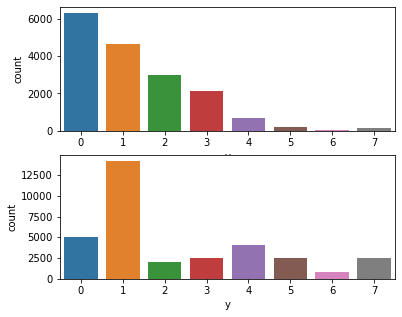

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [17]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [18]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.20572434504408652, 0.13982443650686585)

In [19]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"060_submission.csv","Stratified-Kfold(K=5)","0.205724","0.139824","","CatBoost-Plain特徴量ミニマム"


In [20]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 31 ms


In [21]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 16 ms


In [22]:
imp_df

,feature,importance,fold
0,inningNo,9.446979,1
1,S,11.863830,1
2,O,10.259935,1
3,numRunners,6.519081,1
4,totalPitchingCount,4.185422,1
...,...,...,...
13,isPitcherHandLeft,1.658776,5
14,isBatterPitcher,0.067776,5
15,isBottom,1.867213,5
16,batterTeam,4.987223,5


In [23]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [24]:
coef_df

""
